In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
from scipy.stats import rankdata
from sklearn.preprocessing import MinMaxScaler

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
RANDOM_SEED = 42

In [3]:
df_train = pd.read_csv('C:\\Users\\programirovanie\\main_task.csv')
df_test = pd.read_csv('C:\\Users\\programirovanie\\kaggle_task.csv')
sample_submission = pd.read_csv('C:\\Users\\programirovanie\\sample_submission.csv')

# Предобработка

In [4]:
# Построение гистограммы цифровых признаков с выбросами, а также вывод границ выбросов
def numerical_hist(col, end):

    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))
    data[col].loc[data[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
        .hist(bins=100, range=(0, end), label='Значения')
    data[col].loc[data[col] >= r_side].hist(alpha=0.5, bins=100, range=(0, end),
                                        label='Выбросы')
    plt.legend()
    
    
#Вывод основных статистических данных категориальных признаков
def categorical_data_value(col):

    display(pd.DataFrame(data[col].value_counts()))
    display(data[col].describe())


# Первичный осмотр

In [5]:
df_train.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


In [6]:
df_test.head(2)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


In [7]:
sample_submission.head(2)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5


In [8]:
display('df_train')
df_train.info()
display('df_test')
df_test.info()
display('sample_submission')
sample_submission.info()

'df_train'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


'df_test'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


'sample_submission'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [9]:
# Объединим тренировочную и тестовую выборку в один DF
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [10]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


# Работа с данными

# 1. Подготовка к обработке

### Формат колонок 

In [11]:
# Отформатируем колонки для удобства
data.columns = [i.lower() for i in data.columns]
data.rename({'number of reviews': 'number_of_reviews', 
             'cuisine style' : 'cuisine_style',
            'price range': 'price_range'}, inplace=True, axis=1)
columns = data.columns.tolist()

### Обработка NAN

<AxesSubplot:>

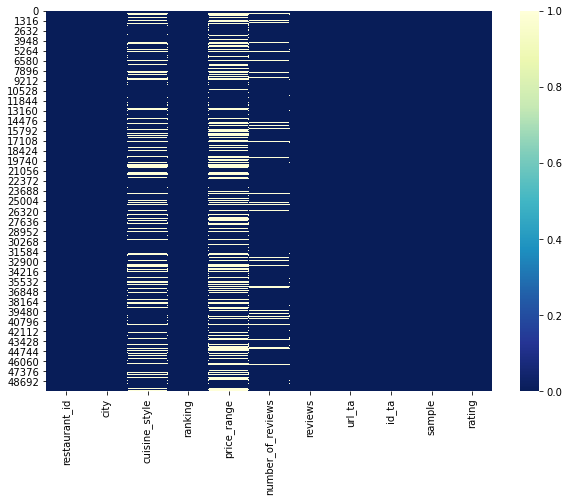

In [12]:
# Оценим пропуски в новом DF
plt.figure(figsize=(10, 7))# размер тепловой карты
sns.heatmap(data.isnull(), cmap="YlGnBu_r")

Заметные пропуски видны в трех переменных 'price_range', 'cuisine_style', 'number_of_reviews'. Отметим их для алгоритма.
Так же есть 2 пропуска в Reviews.

#### was_missing nan 

In [13]:
# Создадим переменные, показывающие наличия пропусков до обработки
cols_with_missing = ['price_range', 'cuisine_style', 'number_of_reviews']

for col in cols_with_missing:
    data[col + '_was_missing'] = data[col].isna()

data.head(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,price_range_was_missing,cuisine_style_was_missing,number_of_reviews_was_missing
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,False,False,False
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,False,False,False
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,False,False,False


#### cuisine_style nan 

In [14]:
# Предположим, что под пропусками скрывается местная кухня
data['cuisine_style'] = data['cuisine_style'].fillna('local')

#### price_range nan 

In [15]:
data['price_range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

Большинство ресторанов принадлежит к второй ценовой категории. Без большого вреда запоним пропуски этой модой

In [16]:
#Заменим пропуски Price Range на самое популярное значение
data['price_range'] = data['price_range'].fillna(data['price_range'].mode()[0])

#### number_of_reviews nan

Посмотрим на пропуски в 'number_of_reviews'

In [17]:
data['number_of_reviews'].min()

2.0

In [18]:
data['number_of_reviews'].head(10)
# Видим пропуск в строке 7

0      4.0
1     97.0
2     28.0
3    202.0
4    162.0
5     24.0
6      2.0
7      NaN
8      2.0
9     13.0
Name: number_of_reviews, dtype: float64

In [19]:
# Посмотрим на отзыв 7 строки
data['reviews'][7]

'[[], []]'

Предположим, что пропуски в number_of_reviews не случайны и обозначают отсутсвие отзывов.

In [20]:
data['number_of_reviews'] = data['number_of_reviews'].fillna(0)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   restaurant_id                  50000 non-null  object 
 1   city                           50000 non-null  object 
 2   cuisine_style                  50000 non-null  object 
 3   ranking                        50000 non-null  float64
 4   price_range                    50000 non-null  object 
 5   number_of_reviews              50000 non-null  float64
 6   reviews                        49998 non-null  object 
 7   url_ta                         50000 non-null  object 
 8   id_ta                          50000 non-null  object 
 9   sample                         50000 non-null  int64  
 10  rating                         50000 non-null  float64
 11  price_range_was_missing        50000 non-null  bool   
 12  cuisine_style_was_missing      50000 non-null 

####  reviews nan

In [22]:
data.reviews.value_counts().head()

[[], []]                                                                                                        8112
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                           2
[['The real codido madrileño'], ['03/31/2017']]                                                                    2
[['Visited the rooftop bar', 'SIXTH FLOOR ROOFTOP BUT YOU CAN ONLY SEE O...'], ['06/27/2017', '10/31/2017']]       2
[['Enjoyable restaurant with indoor and outdo...', 'Delicious food'], ['11/04/2017', '10/31/2017']]                2
Name: reviews, dtype: int64

У нас не только 2 пропуска, так же еще отзывы отсутсвуют в 8112 строках

In [23]:
# Заменими пропуски на Nan
data['reviews']  = data.reviews.fillna('NaN')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   restaurant_id                  50000 non-null  object 
 1   city                           50000 non-null  object 
 2   cuisine_style                  50000 non-null  object 
 3   ranking                        50000 non-null  float64
 4   price_range                    50000 non-null  object 
 5   number_of_reviews              50000 non-null  float64
 6   reviews                        50000 non-null  object 
 7   url_ta                         50000 non-null  object 
 8   id_ta                          50000 non-null  object 
 9   sample                         50000 non-null  int64  
 10  rating                         50000 non-null  float64
 11  price_range_was_missing        50000 non-null  bool   
 12  cuisine_style_was_missing      50000 non-null 

Обработка пропусков закончена.

#### Наличиее дублей

In [25]:
# Проверим датасет на наличие дубликатов:
if len(data)==len(data.drop_duplicates()):
    print('Дубликатов нет')
else:
    print('Дубликаты есть')

Дубликатов нет


## 2. Обработка признаков

### 2.1 restaurant_id

Проверим - есть ли повторы в переменной

In [26]:
# Количество уникальных значений
len(data['restaurant_id'].unique())

13094

Text(0.5, 1.0, 'Распределие пизнака Restaurant_id')

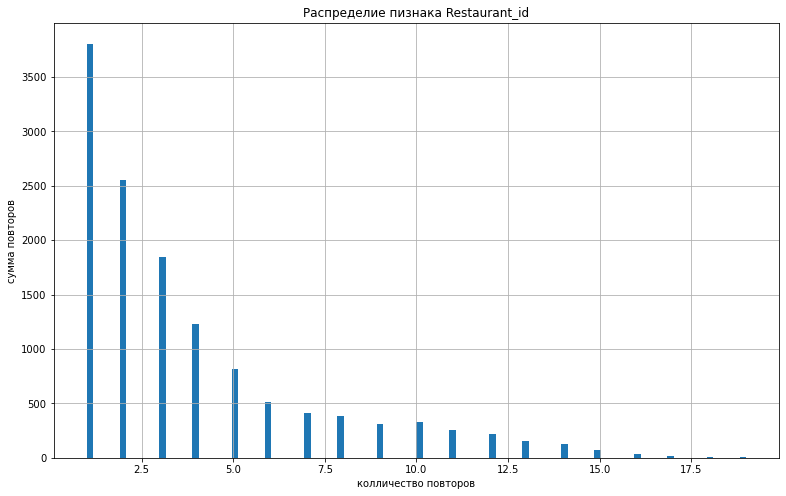

In [27]:
# Проверим распределение признака.
plt.rcParams['figure.figsize'] = (13,8)
ds = data['restaurant_id'].value_counts().hist(bins=100)
ds.set_xlabel('колличество повторов')
ds.set_ylabel('сумма повторов')
ds.set_title('Распределие пизнака Restaurant_id')

In [28]:
# Изменим формат переменной, что бы алгоритм смог обработать показатель.
data['restaurant_id'] = data['restaurant_id'].apply(lambda x: x.split('_')[1])

## 2.2 city

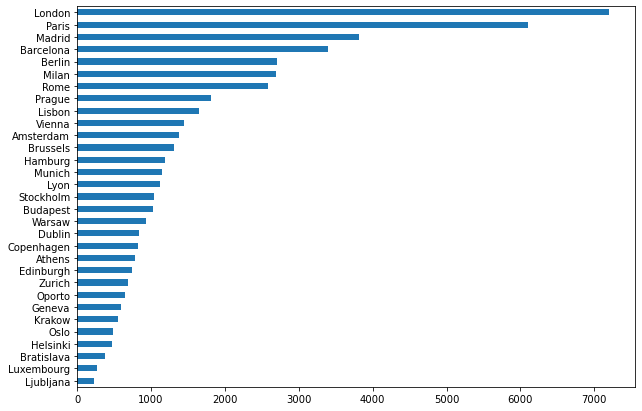

In [152]:
# Посмотрим на количество ресторанов по городам
data['city'].value_counts(ascending=True).plot(kind='barh');

Посмотрим как оценивают рестораны в каждом представленном городе

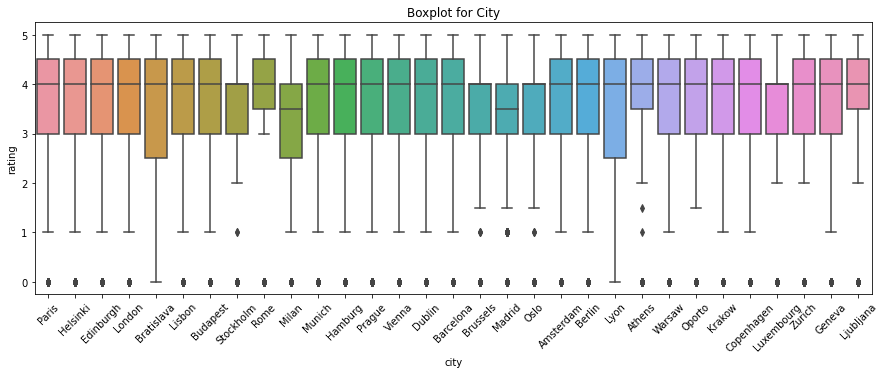

In [29]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='city', y='rating',data=data.loc[
    data.loc[:, 'city'].isin(data.loc[:, 'city'].value_counts().index[:])
],ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for City')

plt.show()

В Риме, Люблиане и Афинах шанс попасть в ресторан с высоким рейтингом выше, чем в остальных.

In [30]:
# Создадим Dummy-переменную для значения город
City_df = pd.get_dummies(data['city'])
data = pd.concat([data, City_df], axis=1)

In [31]:
# Создадим переменную, показывающая город-стлицу (1) или региональный город (0)

# Объявим города-столицы
Capitals = [
        'Athens', 'Bratislava', 'London', 'Paris', 'Madrid', 'Berlin', 'Rome',
        'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
        'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Edinburgh', 'Oslo',
        'Helsinki', 'Luxembourg', 'Ljubljana'
    ]

# Вернем 1 при совпадении с Capitals     
data['is_capital'] = data['city'].apply(lambda x: 1 if x in Capitals else 0)

Создадим признак, который на основании Ranking вычисляет значение Rating

## 2.3 cuisine_style

### Блок функций

In [32]:
# Функция для подсчета количества кухонь в ресторане
def kitchen_len(kitchen): 
    kitchen = str(kitchen)
    new_value = kitchen.split((', '))
    return_value = pd.Series(new_value, copy=False)
    return len(return_value)


# Создадим новую переменную с ресторанами для вегатарианцев
def Vegetarian_Friendly(col):
    Vegetarian = ['Vegetarian Friendly', 'Healthy', 'Vegan Options', 'Gluten Free Options']
    
    for i in Vegetarian:
        if i in col:
            return 1
    else:
        return 0


# Функция для создания новой переменной с барами и пабами
def bar_pub(col):
    
    if "Bar" in col:
        return 1
    if "Pub" in col:
        return 1
    if 'Wine Bar' in col:
        return 1
    else:
        return 0


# Функция для создания новой переменной с азиатской кухней
def Asian_def(col):
    asian = ['Asian', 'Sushi', 'Japanese', 'Chinese', 'Vietnamese', 'Thai']
    
    for i in asian:
        if i in col:
            return 1
    else:
        return 0
    

# Функция для создания новой переменной с европейской кухней
def European_def(col):
    european = ['French', 'Italian', 'Spanish', 'European', 'Portuguese', 
                'Polish', 'German', 'British', 'Greek', 'Czech', 'Scandinavian', 'Central European',
               'Scottish', 'Slovenian', 'Hungarian',  'Swiss', 'Eastern European', 'Irish', 'Pizza']
    
    for i in european:
        if i in col:
            return 1
    else:
        return 0
    
# Функция для создания новой переменной с пиццериями
def pizza_def(col):
    if 'Pizza' in col:
        return 1
    else:
        return 0
    
# Функция для создания новой переменной с фаст-фудом   
def Fast_Food_def(col):
    if 'Fast Food' in col:
        return 1
    else:
        return 0

Создадим новые переменные

In [33]:
# Количество кухонь
data['Number_of_kitchens'] = data['cuisine_style'].apply(kitchen_len)
# Наличие бара/паба в заведении
data['bar_pub'] = data['cuisine_style'].apply(bar_pub)
# Ресторан с вегатарианской едой
data['Vegetarian_Cuisine'] = data['cuisine_style'].apply(Vegetarian_Friendly)
# Азиатские рестораны
data['Asian_Cuisine'] = data['cuisine_style'].apply(Asian_def)   
#  Пиццерия
data['Pizza_Cuisine'] = data['cuisine_style'].apply(pizza_def)
# Европейская кухня
data['European_Cuisine'] = data['cuisine_style'].apply(European_def)
# Фаст фуд
data['Fast_Food_Cuisine'] = data['cuisine_style'].apply(Fast_Food_def)

In [34]:
#Создадим Dummy-переменную для значения каждого набора кухонь
Cuisine_Style_df = pd.get_dummies(data['cuisine_style'])
data = pd.concat([data, Cuisine_Style_df], axis=1)
# Хоть и выглядит странным, но тест показал, что отклонение уменьшается

## 2.4 ranking

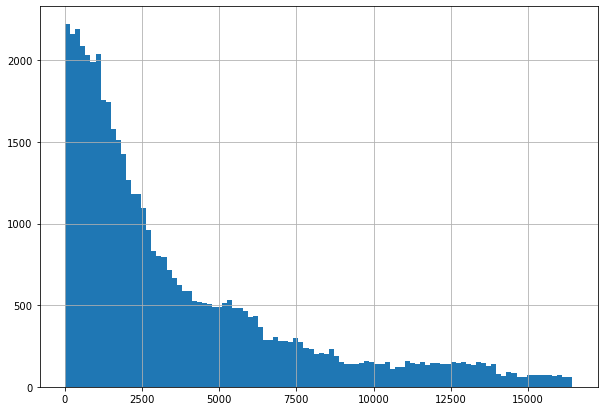

In [150]:
# Ресторанов с низким местом значительно меньше, чем ресторанов с высоким
plt.rcParams['figure.figsize'] = (10,7)
data['ranking'].hist(bins=100);

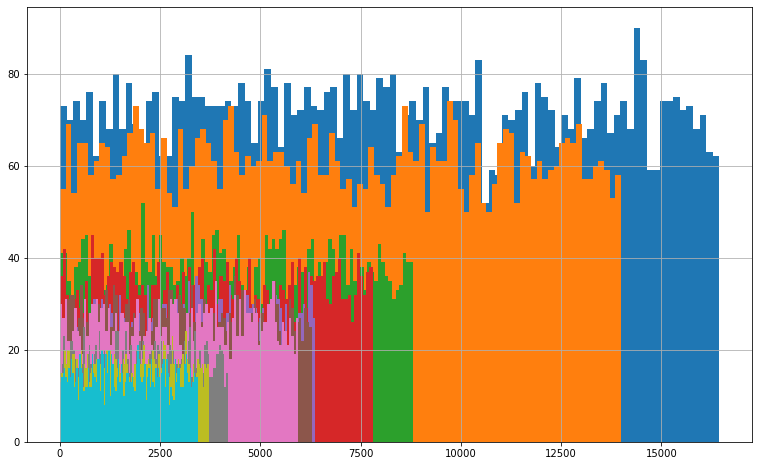

In [35]:
# На этом графике хорошо видно, что рейтинг нарямую зависит от колличества ресторанов в городе.
for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

## 2.5 Price Range

In [36]:
# Функция переводящая оценку дороговизны ресторана в последовательность из чисел
def Price_Range(series):
    if series == "$":
        return 1
    if series == "$$ - $$$":
        return 2
    if series == '$$$$':
        return 3

# Обновим переменную
data['price_range'] = data['price_range'].apply(Price_Range)

In [37]:
data.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample',
       ...
       '['Wine Bar', 'Italian', 'Mediterranean']',
       '['Wine Bar', 'Italian', 'Vegetarian Friendly']',
       '['Wine Bar', 'Italian']',
       '['Wine Bar', 'Mediterranean', 'European', 'Vegetarian Friendly']',
       '['Wine Bar', 'Mediterranean']',
       '['Wine Bar', 'Scottish', 'Vegetarian Friendly']',
       '['Wine Bar', 'Spanish']', '['Wine Bar', 'Vegetarian Friendly']',
       '['Wine Bar']', 'local'],
      dtype='object', length=10785)

## 2.6 number of reviews 

<AxesSubplot:>

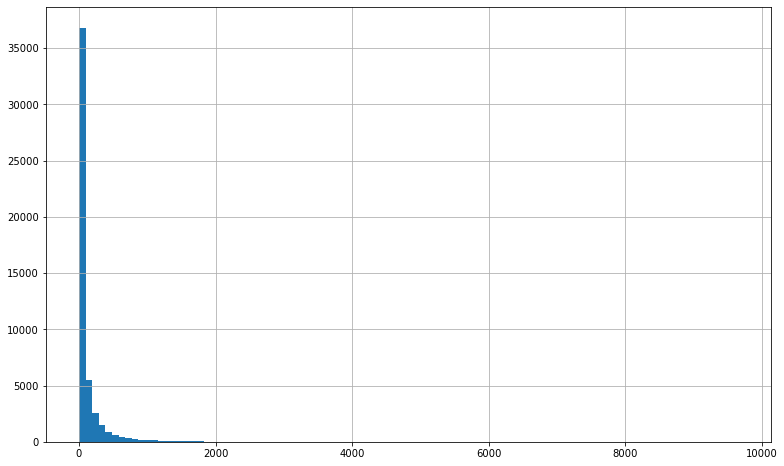

In [38]:
data['number_of_reviews'].hist(bins=100)

25 percentile: 7.0 
75 percentile: 105.0 
Data Outlier Boundaries: 
left: -140.0 
right: 252.0


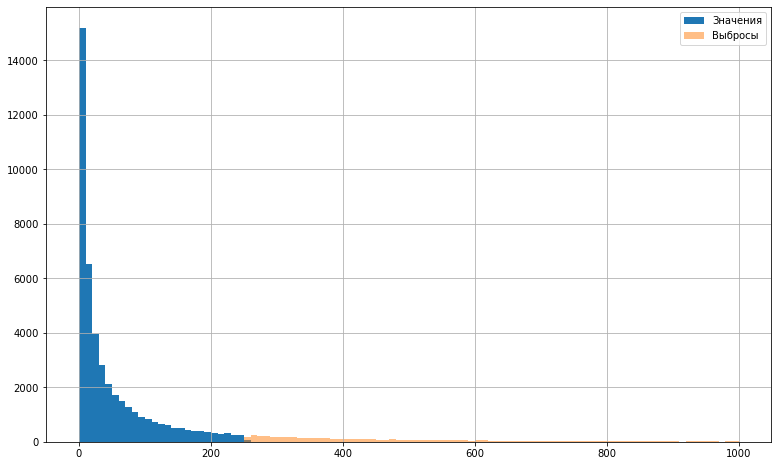

In [39]:
numerical_hist('number_of_reviews', 1000)

Распределение показывает большой разброс значений переменной. Логарифмируем значение

In [40]:
data['number_of_reviews_log'] = np.log(data['number_of_reviews'] + 1)

median = data['number_of_reviews_log'].median()
IQR = data['number_of_reviews_log'].quantile(0.75) - data['number_of_reviews_log'].quantile(0.25)
perc25 = data['number_of_reviews_log'].quantile(0.25)
perc75 = data['number_of_reviews_log'].quantile(0.75)
l_side = perc25 - 1.5*IQR
r_side = perc75 + 1.5*IQR
print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))

25 percentile: 2.0794415416798357 
75 percentile: 4.663439094112067 
Data Outlier Boundaries: 
left: -1.7965547869685108 
right: 8.539435422760413


## 2.7 id_ta

In [95]:
# Проверим наличие повторов ресторанов по данным трипадвизор

0    10746918
1     6674944
2    13129638
3      680417
4     1112354
Name: id_ta, dtype: int64

In [94]:
data['id_ta'] = data['id_ta'].apply(lambda x: int(x[1:]))

<AxesSubplot:>

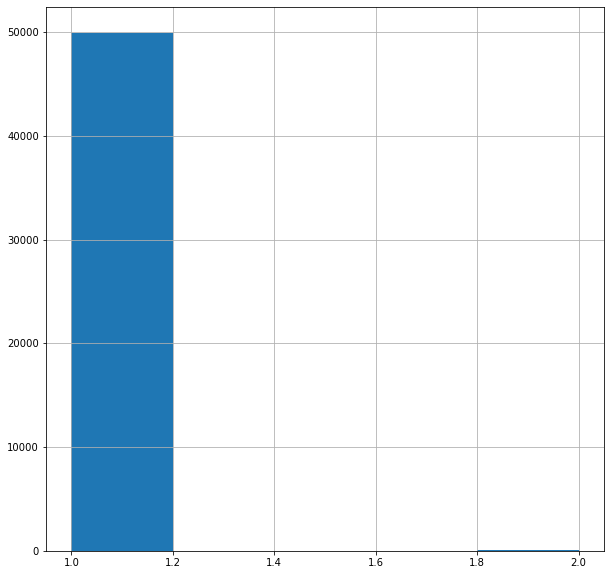

In [100]:
# Находим 2 повтора
data['id_ta'].value_counts().hist(bins=5)

## 2.8 url_ta

<AxesSubplot:>

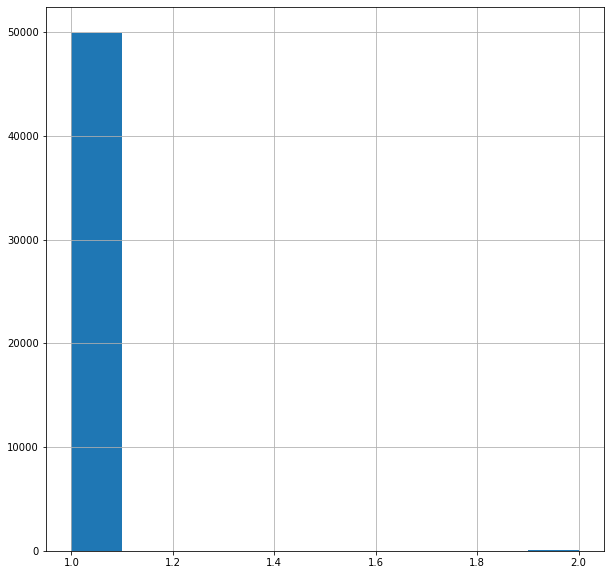

In [111]:
# Гистограмма по распределению похожа на переменную id_ta
data['url_ta'].value_counts().hist()

In [113]:
# По всей видимости - повторы одинаковые
len(data['url_ta'].unique()) == len(data['id_ta'].unique())

True

In [116]:
# Отформатируем переменную, оставив только идентификатор
data['url_ta'] = data.url_ta.str.findall(r"g([\s\S]+?)-").str[0]

В ходе анализа url_ta и id_ta было выявлено, что данные переменные на итоговую метрику не влияют. Удалим далее эти показатели

## Создание новых признаков 

Добавим иформацию о численности жителей

In [41]:
population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

data['population'] = data.city.map(population)

Количество отзывов на 1 человека

In [42]:
data['reviews_per_population'] = data.number_of_reviews_log / data.population

Добавим информацию о покупательной способности населения

In [43]:
purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

data['purchasing_power'] = data.city.map(purchasing_power_index)

Добавим переменную, оценивающую покупательскую способность и ценовую категорию ресторана.

In [44]:
data['purchasing_power_rating'] = data['purchasing_power']/data['price_range']

Создадим переменную-показатель дороговизны ресторана относительно моде.

In [45]:
data['price_ratio'] = data['price_range']/data['price_range'].mode()[0]

Обработаем отзывы и на основе них создадим переменную reviews_rank

In [46]:
# Обработаем отзывы
def Price_Range_new(x):
    best = ['best', 'exelent', 'perfect', 'perfectly', 'excellently',  'superbly',
            'fantastic', 'wonderfully', 'exquisite', 'favorite', 'super', 'top', 'love it',
           'one of the best', 'relaxed']
    good = ['good', 'Very good', 'tasty', 'great', 'lovely', 'nice', 'cool', 'bland ', 'yummy',
            'efficient', 'better', 'pretty', 'very friendly', 'pleasant']
    Ok = ['fine ', 'ok', 'okay', 'not good, not bad', 'no worth the hype', 'nothing special']
    bad = ['bad', 'slow', 'didnt like', 'nozzy', 'stale', 'tasteless', 'insipid', 'unpalatable',
           'lazy', 'scam', 'awful', 'inconsistent', 'disappointing']
     
    x=str(x)
    
    # В зависимости от упоминаний в отзыве вернем оценку ресторану 
    for i in best:
        if i in x:
            return 4
    for i in good:
        if i in x:
            return 3
    for i in Ok:
        if i in x:
            return 2
    for i in bad:
        if i in x:
            return 1
    if x == '[[], []]':
        return np.nan

# Подготовим переменную для обработки
data['reviews'] = data['reviews'].apply(lambda x: str(x))
data['reviews'] = data['reviews'].apply(lambda x: x.lower())
# ПРименим функцию
data['reviews_rank'] = data['reviews'].apply(Price_Range_new)
# Заполним пропуски медианой
data['reviews_rank'] = data['reviews_rank'].fillna(data['reviews_rank'].median())

Обработаем переменную с отзывов и выведем новую переменную с актуальностью отзыва

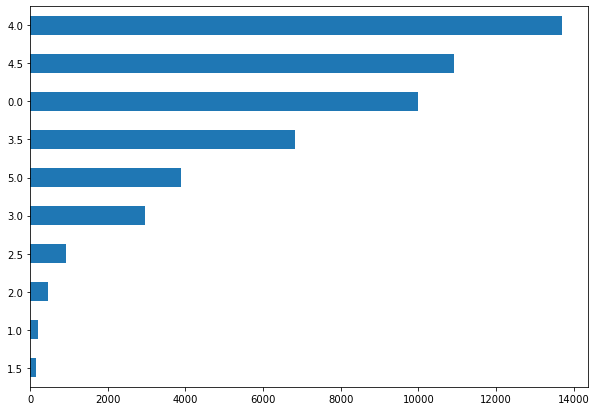

In [151]:
# Посмотрим на нашу целевую переменную
data['rating'].value_counts(ascending=True).plot(kind='barh');

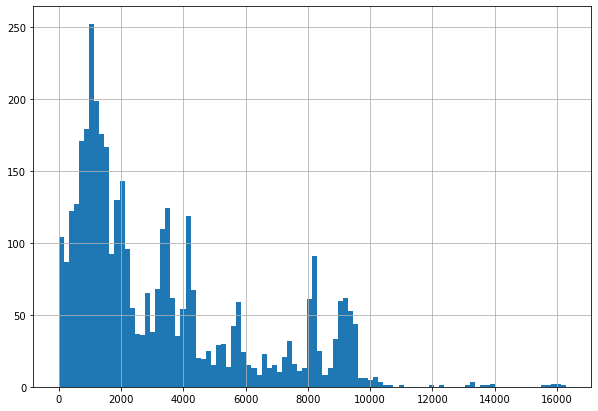

In [155]:
# Высокий рейтинг - не всегда равно высокому рейтингу по городу
data['ranking'][data['rating'] == 5].hist(bins=100);

# Корреляция признаков

На этом графике уже сейчас можно заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

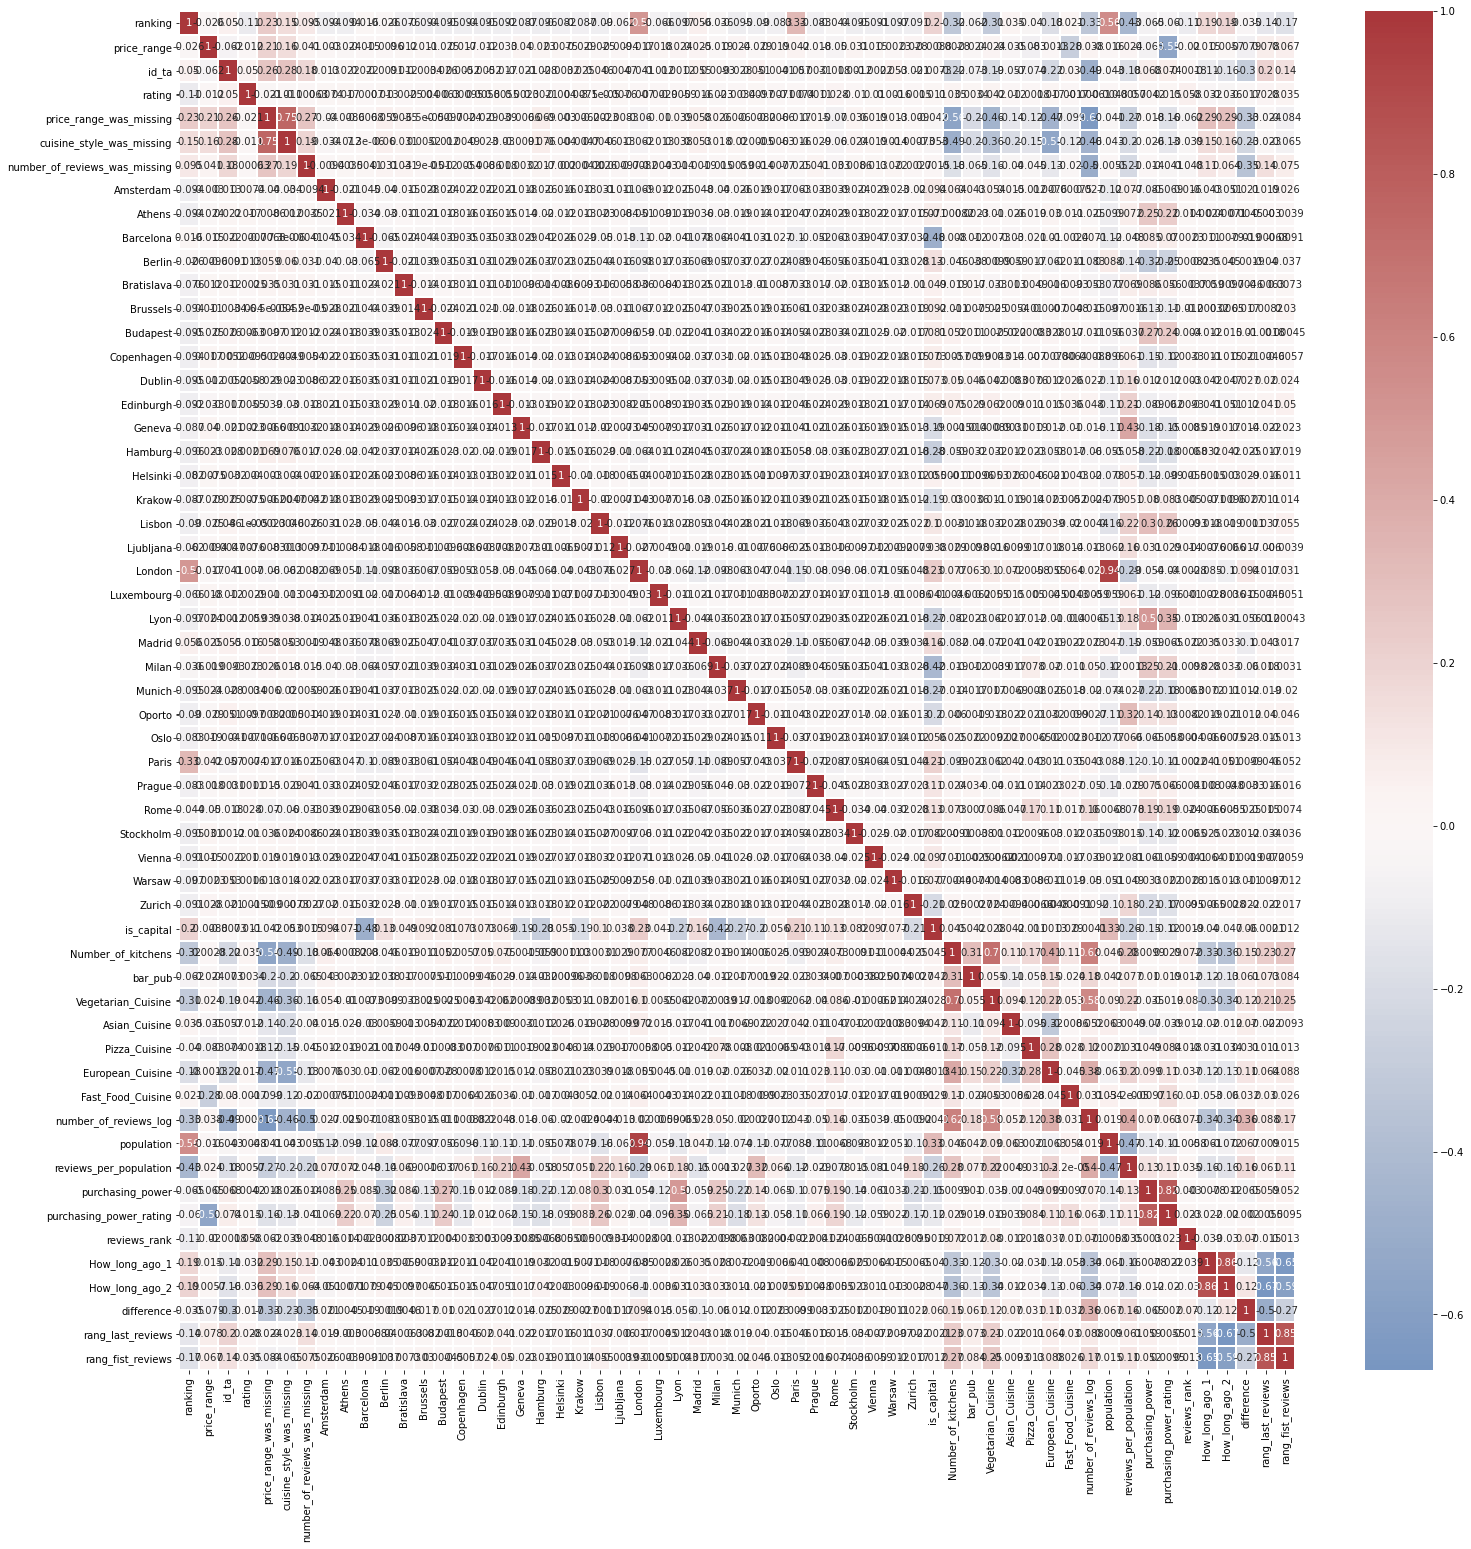

In [117]:
col_for_drop = ['sample', 'number_of_reviews']
data_corr = data.drop(Cuisine_Style_df, axis=1)
data_corr = data_corr.drop(col_for_drop, axis = 1)
#sns.heatmap(food_corr.corr())

correlation = data_corr.corr()
ax = plt.subplots(figsize=(25, 25))
sns.heatmap(correlation, annot=True, cmap='vlag', linewidths=1, center=0)

Видим прямую заявисимость price_range и price_ratio. Идея добавить price_range оказалась плхой

In [119]:
# Удалим переменную price_ratio
data = data.drop('price_ratio', axis=1)

In [148]:
# Удалим категориальные признаки
data_to_test = data.drop(['city', 'cuisine_style', 'reviews', 'url_ta', 'id_ta'], axis=1) #  

In [147]:
# Переменные с временем не пригодились, без них показатель отклонения ниже
data_to_test2 = data_to_test.drop(['difference', 'rang_fist_reviews', 'rang_last_reviews',
                                   'rang_last_reviews', 'rang_fist_reviews'], axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели


In [134]:
# Теперь выделим тестовую часть
train_data = data_to_test2.query('sample == 1').drop(['sample'], axis=1)
test_data = data_to_test2.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

In [124]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [135]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [136]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 10791), (40000, 10791), (40000, 10790), (32000, 10790), (8000, 10790))

# Создаём, обучаем и тестируем модель

In [127]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [137]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [138]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [139]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20107499999999998


<AxesSubplot:>

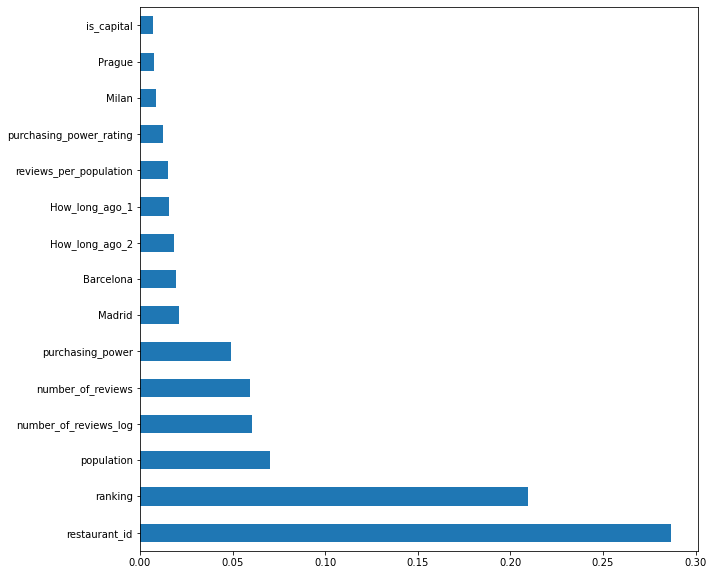

In [140]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
# 0.2009275 рекорд // data to test 0.20416187500000002 // data_to_test2 (без анализа времени) 0.20107499999999998

# Kygle

In [141]:
test_data.sample(10)

,restaurant_id,ranking,price_range,number_of_reviews,rating,price_range_was_missing,cuisine_style_was_missing,number_of_reviews_was_missing,Amsterdam,Athens,...,reviews_per_population,purchasing_power,purchasing_power_rating,reviews_rank,How_long_ago_1,How_long_ago_2,Day_of_week_1,Day_of_week_2,Month_1,Month_2
8289,8289,2553.0,2,104.0,0.0,False,False,False,0,0,...,3.324590e-06,40,20.0,3.0,1240.0,1343.0,4,6,08,04
4807,4807,549.0,2,39.0,0.0,False,False,False,0,0,...,1.282683e-05,42,21.0,3.0,1049.0,1230.0,6,0,02,08
8387,8387,756.0,2,93.0,0.0,False,False,False,0,0,...,8.192700e-06,27,13.5,3.0,1138.0,1148.0,1,5,11,11
3712,3712,1400.0,2,46.0,0.0,True,True,False,0,0,...,7.460196e-06,70,35.0,3.0,1169.0,1227.0,5,3,10,08
1580,1580,871.0,2,88.0,0.0,False,False,False,0,0,...,8.697357e-06,70,35.0,3.0,1120.0,1093.0,5,4,12,01
260,260,856.0,2,164.0,0.0,False,False,False,0,0,...,1.010026e-05,48,24.0,3.0,1181.0,1358.0,0,5,10,04
343,343,711.0,3,596.0,0.0,False,False,False,0,0,...,3.944793e-06,30,10.0,3.0,1173.0,1180.0,1,1,10,10
3053,3053,4818.0,2,84.0,0.0,False,False,False,0,0,...,4.986655e-07,24,12.0,3.0,1120.0,1445.0,5,2,12,01
9814,9814,8246.0,2,24.0,0.0,True,True,False,0,0,...,9.986169e-07,23,11.5,3.0,1097.0,1097.0,0,0,12,12
4020,4020,7933.0,2,9.0,0.0,False,False,False,0,0,...,7.143489e-07,23,11.5,3.0,1655.0,1655.0,2,2,06,06


In [142]:
test_data = test_data.drop(['rating'], axis=1)

In [143]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [144]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [145]:
predict_submission

array([4.375, 4.385, 4.54 , ..., 2.75 , 3.3  , 4.015])

In [146]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,4.375
1,id_1,4.385
2,id_2,4.540
3,id_3,4.345
4,id_4,4.545
5,id_5,4.615
6,id_6,4.190
7,id_7,3.865
8,id_8,4.680
9,id_9,4.695
